In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

In [2]:
file_path = "../results/results_1x.csv"
results_1x = pd.read_csv("../results/results_1x.csv")
results_1x.head(3)

,Backbone,COCO format,Epochs,Lr initial,Lr step,Batch Size,Best AP,Best AP epoch,Best AR,Best AR epoch
0,DLA,gray,10,0.005,0,8,0.0012,8.0,0.0075,8.0
1,DLA,gray,10,0.005,0,16,0.0022,6.0,0.0204,4.0
2,DLA,gray,10,0.005,0,32,0.0889,2.0,0.1732,2.0


In [3]:
results_1x.dropna(inplace=True)
results_1x["Best AP Epoch"] = pd.to_numeric(results_1x["Best AP epoch"], downcast='integer')
results_1x["Best AR Epoch"] = pd.to_numeric(results_1x["Best AR epoch"], downcast='integer')
results_1x["Batch Size"] =results_1x["Batch Size"].astype(int)

In [4]:
def filter_values(scores,backbone):
    return (scores[(scores["Backbone"]==backbone) & (scores["Lr step"] == '0') & 
                (scores["Epochs"]<20)])

In [5]:
dla_search = filter_values(results_1x,'DLA')
hourglass_search = filter_values(results_1x,'Hourglass')
hrnet_search = filter_values(results_1x,'HRNet')

In [6]:
def plot_lr_search(df, backbone, score_name):
    colors = ["deepskyblue","plum","limegreen"]
    if "DLA" in backbone:
        diff_lr = [0.005,0.0005,0.00005]
    elif "Hourglass" in backbone:
        diff_lr = [0.0025,0.00025,0.000025]
    elif "HRNet" in backbone:
        diff_lr = [0.01,0.001,0.0001]
    fig, ax = plt.subplots(figsize=(9,9))
    sb.stripplot(x='Batch Size',y='Best {}'.format(score_name),marker="*",jitter=False,s=14,alpha=0.9,linewidth=1,
               hue='Lr initial',data=df[df['COCO format'] == 'color'],ax=ax,palette=colors)
    sb.stripplot(x='Batch Size',y='Best {}'.format(score_name),marker="o",jitter=False,s=12,alpha=0.9,linewidth=1,\
               hue='Lr initial',data=df[df['COCO format'] == 'gray'],ax=ax,palette=colors)
    
    blue_patch = mpatches.Patch(color=colors[0], label='lr={:.1e}'.format(diff_lr[2])) 
    orange_patch = mpatches.Patch(color=colors[1], label='lr={:.1e}'.format(diff_lr[1]))                                                               
    green_patch = mpatches.Patch(color=colors[2],label='lr={:.1e}'.format(diff_lr[0])) 
    color_marker = mlines.Line2D([], [], color='k',marker='*',linewidth=1,
                         markersize=10, label='color',linestyle='None',fillstyle='none')
    gray_marker = mlines.Line2D([], [], color='k',marker='o',linewidth=1,
                         markersize=10, label='gris',linestyle='None',fillstyle='none')
    plt.legend(handles=[green_patch,orange_patch,blue_patch,gray_marker,color_marker],loc='center right')
    ax.grid(True,which='major',axis='y',linewidth=1.0)
    ax.grid(True,which='minor',axis='y',linewidth=0.5)
    ax.minorticks_on()
    plt.title("{} \n {} para diferentes combinaciones de learning rate y batch size".format(backbone,score_name),
             fontsize=14)
    plt.tick_params(axis='x',which='both',bottom=False)
    plt.ylabel(score_name,fontsize=12)
    plt.xlabel("Batch size",fontsize=12)
    plt.savefig("../figures/exp_plots/lr_search/{}_lr_{}.png".format(backbone,score_name))
    plt.show()

### Plot lr-bs exploration for each backbone 

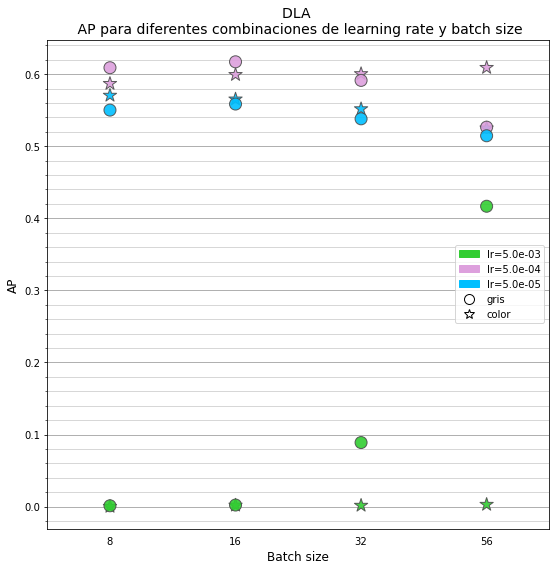

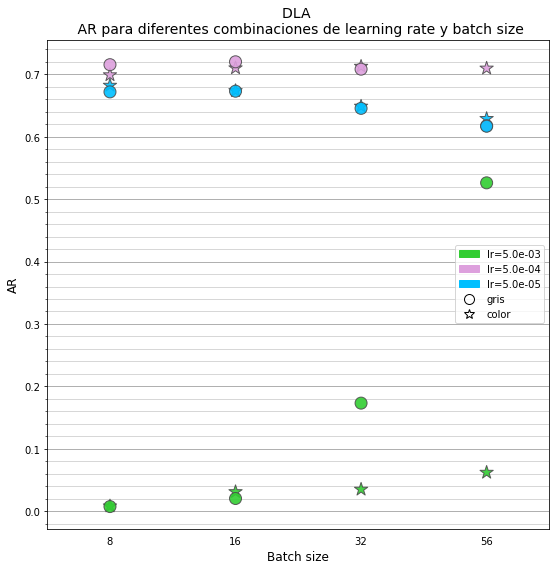

In [72]:
plot_lr_search(dla_search,"DLA","AP")
plot_lr_search(dla_search,"DLA","AR")

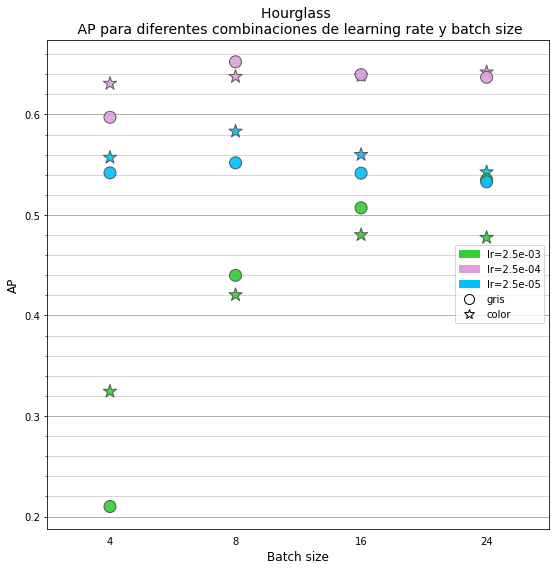

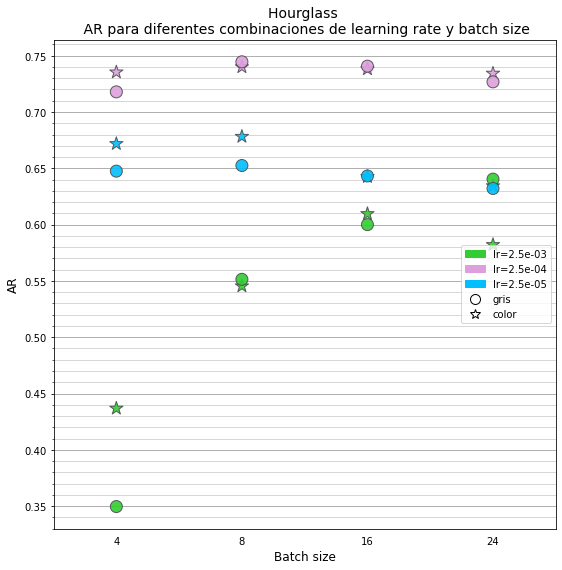

In [73]:
plot_lr_search(hourglass_search,"Hourglass","AP")
plot_lr_search(hourglass_search,"Hourglass","AR")

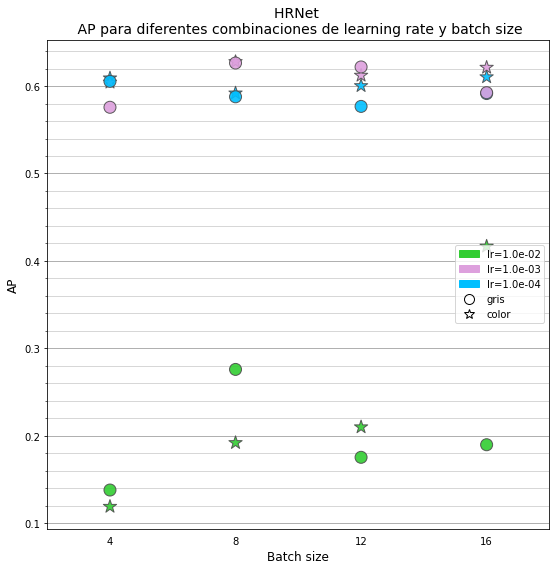

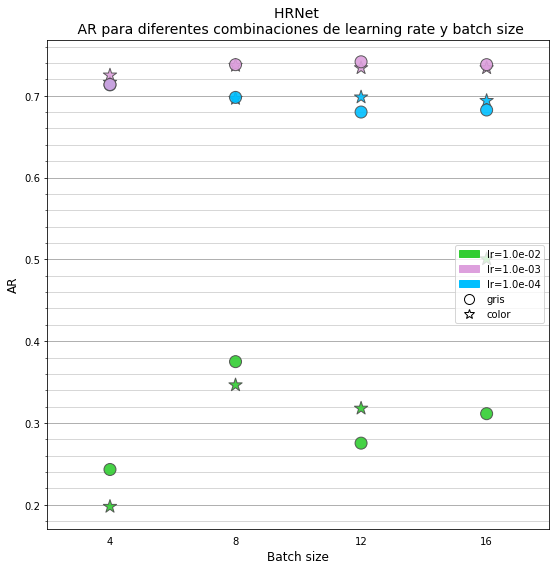

In [74]:
plot_lr_search(hrnet_search,"HRNet","AP")
plot_lr_search(hrnet_search,"HRNet","AR")

### Extract Useful information, about the dataset, from annotations

In [7]:
import json

In [8]:
train_anns_path = "../CenterNet/data/thermal_pose/annotations/thermalPose_train.json"
test_anns_path = "../CenterNet/data/thermal_pose/annotations/thermalPose_val.json"
with open(train_anns_path,'r') as f:
    train_anns = json.loads(f.read())
with open(test_anns_path,'r') as f:
    test_anns = json.loads(f.read())

In [9]:
def get_image_sizes(anns):
    imgs_info = anns['images']
    imgs_sizes = {img['id']:(img['width'],img['height']) for img in imgs_info}
    return imgs_sizes

In [14]:
print("Ammount of People Labeled Train Set: {}".format(len(train_anns['annotations'])))
print("Ammount of People Labeled Test Set: {}".format(len(test_anns['annotations'])))
print("Total Ammount of People Labeled: {}".format(len(test_anns['annotations']+train_anns['annotations'])))

Ammount of People Labeled Train Set: 927
Ammount of People Labeled Test Set: 291
Total Ammount of People Labeled: 1218


In [47]:
train_img_sizes = get_image_sizes(train_anns)
test_img_sizes = get_image_sizes(test_anns)
print("Average Ammount of People per Image (Train Set): {}".format(len(train_anns['annotations'])/600))
print("Average Ammount of People per Image (Test Set): {}".format(len(test_anns['annotations'])/200))

Average Ammount of People per Image (Train Set): 1.545
Average Ammount of People per Image (Test Set): 1.455


In [53]:
def extract_relative_sizes(anns,sizes):
    rel_sizes = []
    for ann in anns['annotations']:
        img_id = ann['image_id']
        bbox_size = ann['area']
        img_size = sizes[img_id][0]*sizes[img_id][1]
        rel = bbox_size/img_size
        rel_sizes.append(rel)
    return np.array(rel_sizes)
    
rel_sizes_train = extract_relative_sizes(train_anns,train_img_sizes)
rel_sizes_test = extract_relative_sizes(test_anns,test_img_sizes)

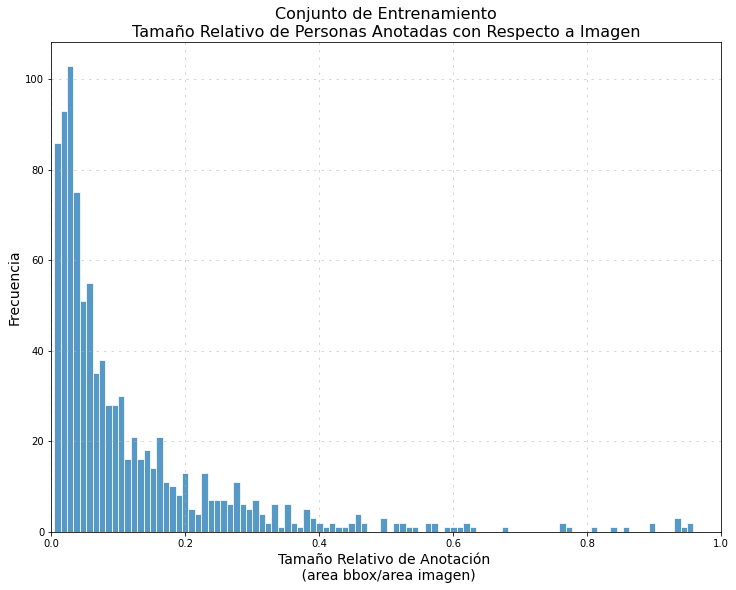

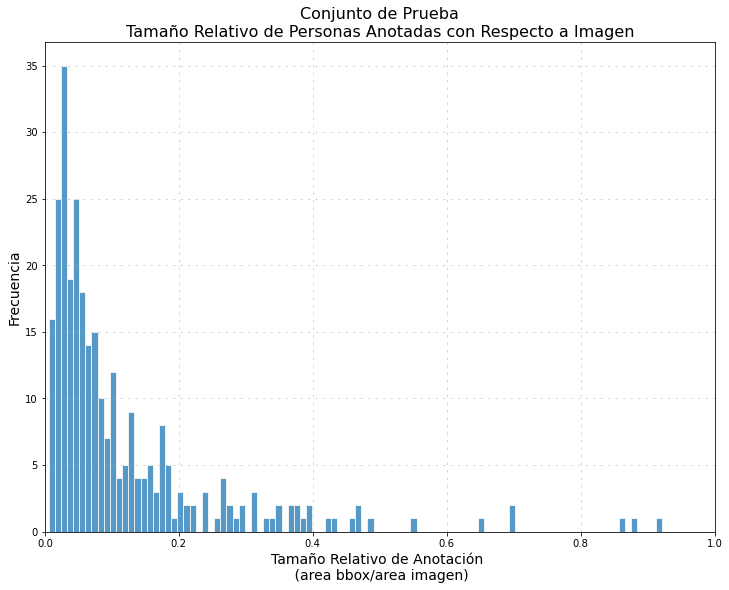

In [105]:
def rel_sizes_hist(rel_sizes,set_name):
    fig = plt.figure(figsize=(12,9))
    plt.grid(True,which='major',axis='both',linewidth=0.5,linestyle=(0,(5,10)))
    plt.hist(rel_sizes, bins=100,align='mid',alpha=0.75,ec='white')
    plt.xlabel('Tamaño Relativo de Anotación \n (area bbox/area imagen)',fontsize=14)
    plt.ylabel('Frecuencia',fontsize=14)
    plt.title('Conjunto de {}\nTamaño Relativo de Personas Anotadas con Respecto a Imagen'.format(set_name),
             fontsize=16)
    plt.xlim([0,1.0])
    plt.savefig('../figures/dataset_description/rel_sizes_{}.png'.format(set_name))
    plt.show()

rel_sizes_hist(rel_sizes_train,'Entrenamiento')
rel_sizes_hist(rel_sizes_test,'Prueba')

In [143]:
def get_marked_kpts(anns,include_not_visible=False):
    count_marked_kpts = np.zeros(17)
    for ann in anns['annotations']:
        marked_kpts = np.array(ann['keypoints'][2::3])
        if not include_not_visible:
            marked_kpts[marked_kpts==1] = 0
        marked_kpts[marked_kpts==2] = 1
        count_marked_kpts += marked_kpts
    kpt_names = ["nose","left eye","right eye","left ear","right ear","left shoulder","right shoulder",\
                 "left elbow","right elbow","left wrist","right wrist","left hip", "right hip",\
                 "left knee","right knee","left ankle","right ankle"]
    counted_dict = {kpt_names[i]:count_marked_kpts[i] for i in range(17)}
    counted = pd.Series(counted_dict)
    return counted
print("Frecuencia de anotaciones de keypoints (Train): \n{}".format(get_marked_kpts(train_anns)))
print("Frecuencia de anotaciones de keypoints (Test): \n{}".format(get_marked_kpts(test_anns)))

Frecuencia de anotaciones de keypoints (Train): 
nose              543.0
left eye          404.0
right eye         411.0
left ear          392.0
right ear         392.0
left shoulder     767.0
right shoulder    765.0
left elbow        673.0
right elbow       655.0
left wrist        572.0
right wrist       573.0
left hip          739.0
right hip         759.0
left knee         739.0
right knee        735.0
left ankle        706.0
right ankle       724.0
dtype: float64
Frecuencia de anotaciones de keypoints (Test): 
nose              194.0
left eye          146.0
right eye         165.0
left ear          136.0
right ear         163.0
left shoulder     236.0
right shoulder    250.0
left elbow        216.0
right elbow       242.0
left wrist        196.0
right wrist       211.0
left hip          223.0
right hip         241.0
left knee         239.0
right knee        251.0
left ankle        229.0
right ankle       238.0
dtype: float64


## Plot experiments over COCO dataset

In [90]:
import glob, os, csv, ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [93]:
reports_path = "../CenterNet/reports/*"
reports_files = glob.glob(reports_path)
experiments = [exp_path.split("/")[-1] for exp_path in reports_files]

def get_opt_file(opt_path):
    opts = []
    with open(opt_path,'r') as file:
        reader = csv.reader(file,delimiter="\n")
        for row in reader:
            row = row[0].lstrip()
            opts.append(row)
    opts = opts[5:]
    opts_dict = {item.split(":")[0]:item.split(":")[1].lstrip() for item in opts}
    opts_dict['lr_step'] = ast.literal_eval(opts_dict['lr_step'])
    return opts_dict


def gather_results():
    header = ["AP","AP0.5","AP0.95","APM","APL","AR","AR0.5","AR0.95","ARM","ARL"]
    data = {}
    opts = {}
    for exp in experiments:
        reports_dir = "../CenterNet/reports/{}".format(exp)
        reports = glob.glob(reports_dir+"/*.csv")
        opt_path = "../CenterNet/reports/{}/train_opt.txt".format(exp)
        if os.path.isfile(opt_path):
            opts[exp] = get_opt_file(opt_path)
        for rep in reports:
            model_epoch = rep.split("/")[-1].split(".")[0].split("_")[-1]
            model_arch = rep.split("_")[0]
            model_domain = rep.split("_")[2]			
            with open(rep,"r") as csvFile:
                reader = csv.reader(csvFile)
                scores = map(float,next(reader))
                data[(exp,model_epoch)] = scores
    df = pd.DataFrame(data).T
    df.columns = header
    model = df.index.get_level_values(0)
    epochs = df.index.get_level_values(1).astype(float)
    df["epoch"] = epochs
    df.index = model
    df['arch'] = df.apply(lambda row: row.name.split("_")[0],axis=1)
    df['regime'] = df.apply(lambda row: row.name.split("_")[1],axis=1)
    df['domain'] = df.apply(lambda row: row.name.split("_")[2],axis=1)
    return df, opts

In [94]:
scores, opts = gather_results()
scores.head(4)

,AP,AP0.5,AP0.95,APM,APL,AR,AR0.5,AR0.95,ARM,ARL,epoch,arch,regime,domain
hg_3x_gray_finetune_mb4_bs8_lr3.5e-4,0.714245,0.942761,0.836355,0.657299,0.788022,0.794643,0.982143,0.896429,0.754237,0.850000,18.0,hg,3x,gray
hg_3x_gray_finetune_mb4_bs8_lr3.5e-4,0.672891,0.905489,0.808304,0.607564,0.757597,0.759286,0.960714,0.864286,0.723729,0.813158,4.0,hg,3x,gray
hg_3x_gray_finetune_mb4_bs8_lr3.5e-4,0.622770,0.890707,0.765339,0.538825,0.759367,0.740714,0.960714,0.860714,0.675424,0.815789,2.0,hg,3x,gray
hg_3x_gray_finetune_mb4_bs8_lr3.5e-4,0.715721,0.943631,0.832778,0.664830,0.785909,0.796786,0.982143,0.892857,0.761017,0.850000,20.0,hg,3x,gray


In [106]:
def plot_score_diff_domains(scores, score_name, model):
    experiment = "{}_1x".format(model)
    scores_1x_color = scores.loc["{}_color".format(experiment)].sort_values(by='epoch')
    scores_1x_thermal = scores.loc[f"{experiment}_thermal"].sort_values(by='epoch')
    fig, ax = plt.subplots(1,1,figsize=(9,8))
    scores_1x_color.plot(x='epoch',y=score_name,style='*',ax=ax,linestyle='dashdot',
                        label='color',color="red")
    scores_1x_thermal.plot(x='epoch',y=score_name,style="*",linestyle='dashdot',ax=ax,label='gris')
    plt.legend(loc='upper left')
    if model=='dla':
        model_title = "DLA"
    elif model=='hg':
        model_title="Hourglass"
    elif model=='hrnet':
        model_title="HRNet"
    plt.title("{}\n AP para entrenamiento en COCO color y gris".format(model_title, score_name),
             fontsize=16)
    ax.set_ylabel(score_name,fontsize=14)
    ax.set_xlabel("Época",fontsize=14)
    ax.grid("minor",alpha=0.5)
    plt.savefig("../figures/exp_plots/{}_1x/{}_color_vs_gray.png".format(model,score_name))

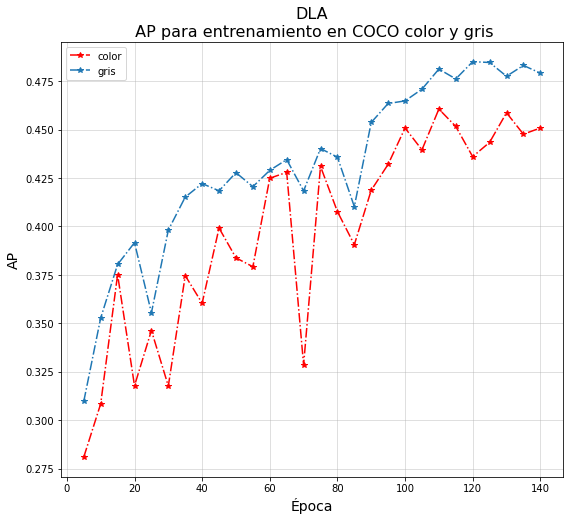

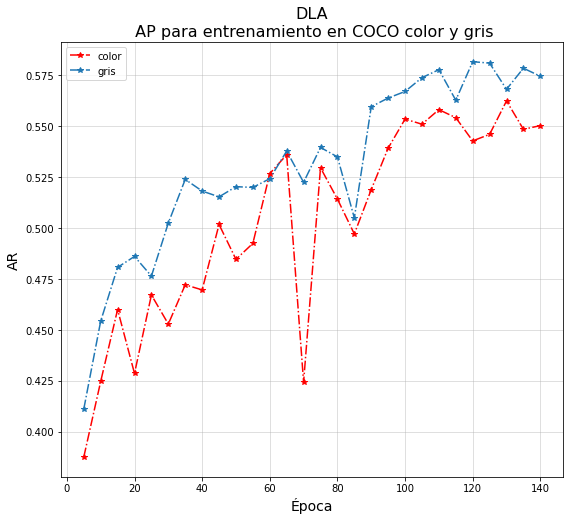

In [107]:
plot_score_diff_domains(scores, "AP","dla")
plot_score_diff_domains(scores,"AR","dla")

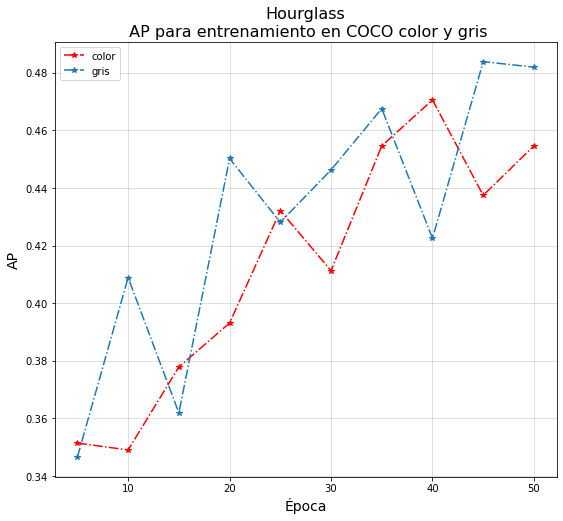

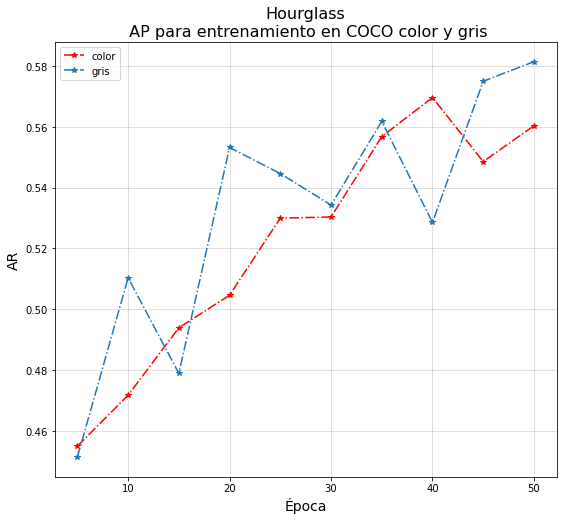

In [108]:
plot_score_diff_domains(scores,"AP","hg")
plot_score_diff_domains(scores,"AR","hg")

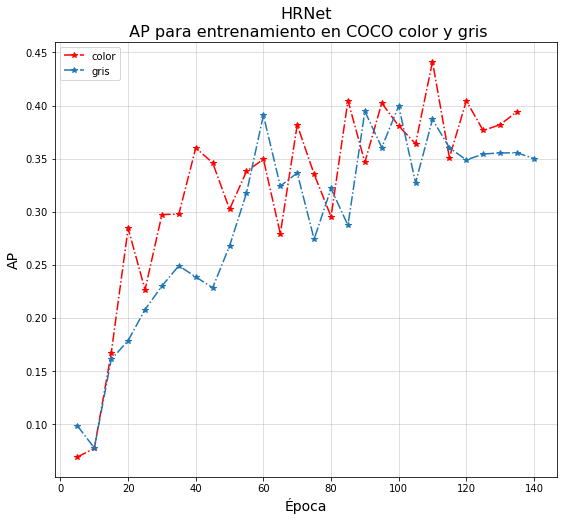

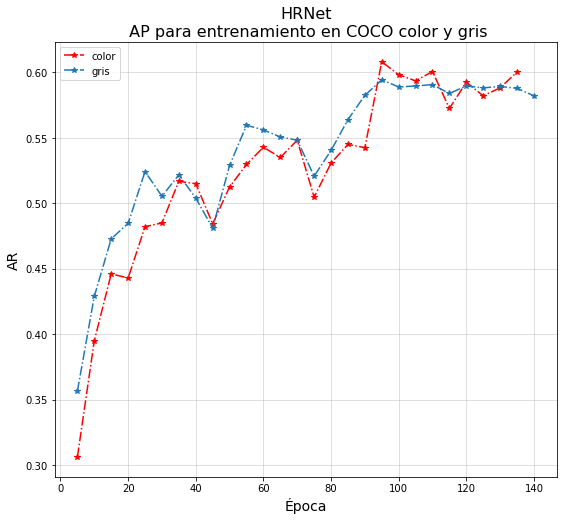

In [109]:
plot_score_diff_domains(scores,"AP","hrnet")
plot_score_diff_domains(scores,"AR","hrnet")

## Plots for Different Freezing Regimes

In [4]:
freeze_dla = [[0.6922,0.7679],[0.6916,0.7718],[0.6933,0.7664],\
              [0.6812,0.7636],[0.6656,0.7629],[0.6361,0.7279],\
              [0.5158,0.5943]]
freeze_hg = [[0.7002,0.7882],[0.7172,0.7982],[0.7135,0.7943],\
             [0.6397,0.7454],[0.5103,0.5961]]

freeze_dla = np.array(freeze_dla).T
freeze_hg = np.array(freeze_hg).T

In [5]:
df_dla_frz = pd.DataFrame(data=freeze_dla,columns=['None','Freeze 1','Freeze 2',\
                                                  'Freeze 3', 'Freeze 4','Freeze 5',\
                                                  'Freeze 6'],index=['AP','AR'])
df_hg_frz = pd.DataFrame(data=freeze_hg,columns=['None','Freeze 1','Freeze 2',\
                                                  'Freeze 3', 'Freeze 4'],index=['AP','AR'])
df_dla_frz.head(3)

,None,Freeze 1,Freeze 2,Freeze 3,Freeze 4,Freeze 5,Freeze 6
AP,0.6922,0.6916,0.6933,0.6812,0.6656,0.6361,0.5158
AR,0.7679,0.7718,0.7664,0.7636,0.7629,0.7279,0.5943


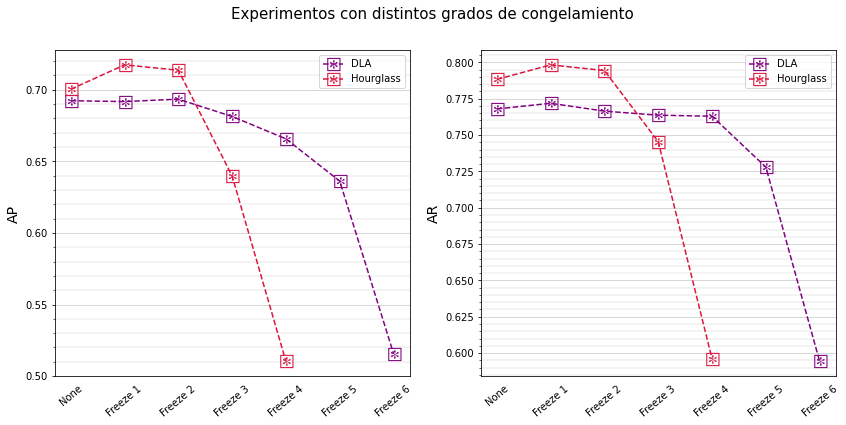

In [6]:
fig, ax = plt.subplots(1,2,figsize=(14,6))
marker = "$%s$" % u'\u29C6'
df_dla_frz.loc['AP'].plot(ax=ax[0],marker=marker,linestyle='dashed',color='purple',
                          markersize=14,markeredgewidth=0.0)
df_hg_frz.loc['AP'].plot(ax=ax[0],marker=marker,linestyle='dashed',color='crimson',
                         markersize=14,markeredgewidth=0.0)
df_dla_frz.loc['AR'].plot(ax=ax[1],marker=marker,linestyle='dashed',color='purple',
                          markersize=14,markeredgewidth=0.0)
df_hg_frz.loc['AR'].plot(ax=ax[1],marker=marker,linestyle='dashed',color='crimson',
                         markersize=14,markeredgewidth=0.0)
plt.suptitle("Experimentos con distintos grados de congelamiento",fontsize=15)
ax[0].set_ylabel('AP',fontsize=14)
ax[1].set_ylabel('AR',fontsize=14)
for sp_ax in ax:
    sp_ax.set_xticks(np.arange(len(df_dla_frz.columns)))
    sp_ax.set_xticklabels(df_dla_frz.columns)
    sp_ax.grid(True,which='major',axis='y',linewidth=0.5)
    sp_ax.grid(True,which='minor',axis='y',linewidth=0.3)
    sp_ax.minorticks_on()
    sp_ax.tick_params(axis='x',which='both',bottom=False,rotation=40)
    sp_ax.legend(["DLA","Hourglass"])
plt.savefig("../figures/exp_plots/diff_frz/frz_exploration.png")
plt.show()